# Uncertainty Quantification

In [3]:
import os
os.environ['HTTPS_PROXY'] = 'http://sisproxy.hkg.agoda.local:3128/'
os.environ['HTTP_PROXY'] = 'http://sisproxy.hkg.agoda.local:3128/'
os.environ['NO_PROXY'] = '$no_proxy,agodadev.io,agoda.local'

In [4]:
!pip install torch torchvision

In [5]:
!nvidia-smi

Sat Mar 28 18:54:13 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:12:00.0 Off |                    0 |
| N/A   34C    P0    34W / 250W |    815MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:AF:00.0 Off |                    0 |
| N/A   32C    P0    34W / 250W |    813MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import torch
from torch import nn
from IPython.display import clear_output, display
import GPUtil
%matplotlib inline

## Define a one dimensional function with varying gaussian noise: 
## $\ \ \ y = 2x + 3xsin(5\pi x) + \epsilon$
## where
## $\ \ \ \epsilon\sim\mathcal{N}(0, \sigma)$
## and
## $\ \ \ \sigma\sim \mathscr{U}(0,x)$


In [7]:
np.random.seed(123)
n = 600
c = 1
x = np.linspace(0, 1, n).reshape(n,1)
s, eps = np.array([]), np.array([])
for k in range(n):
    s = np.append(s, np.random.uniform(0,x[k],(1,)))
    eps = np.append(eps, np.random.normal(loc=0, scale=c*s[k], size=(1,)))
s = s.reshape([n,1])
eps = eps.reshape([n,1])
y_ = 2*x + 3*x*np.sin(5*np.pi*x)
y = y_ + eps

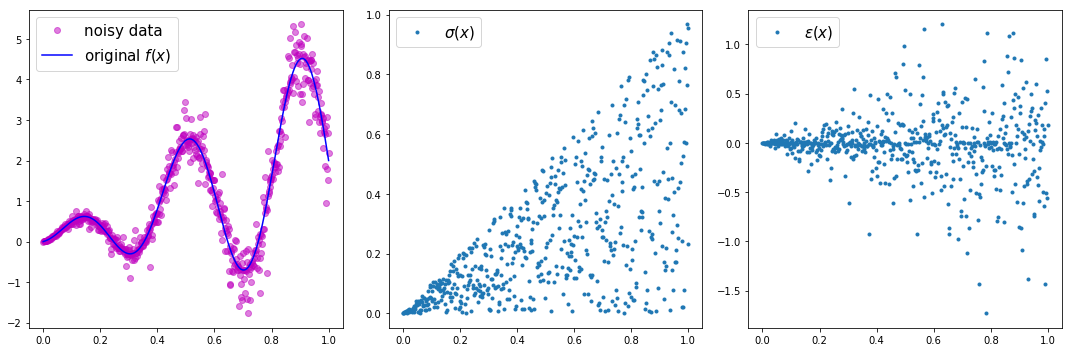

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.plot(x,y,'mo', alpha=0.5, label='noisy data');
plt.plot(x,y_,'b-',label='original $f(x)$');
plt.legend(fontsize=15)
plt.subplot(1,3,2)
plt.plot(x,s,'.',label='$\sigma(x)$')
plt.legend(fontsize=15)
plt.subplot(1,3,3)
plt.plot(x,eps,'.',label='$\epsilon(x)$')
plt.legend(fontsize=15)
plt.tight_layout();

In [9]:
inds = list(range(x.shape[0]))
np.random.shuffle(inds)
c = 0.5
tr_ind, ts_ind = sorted(inds[:int(c*x.shape[0])]), sorted(inds[int(c*x.shape[0]):])
x_train, y_train, x_test, y_test = x[tr_ind], y[tr_ind], x[ts_ind], y[ts_ind]
x_train.shape, x_test.shape

((300, 1), (300, 1))

# Polynomial regression

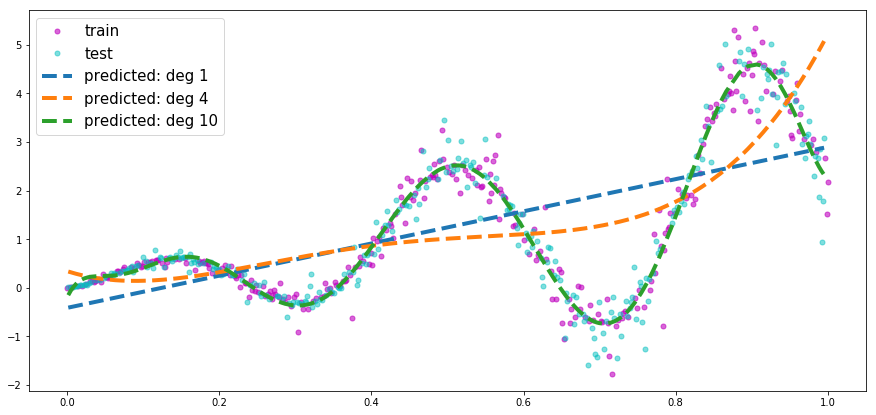

In [8]:
plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'m.', ms=10, alpha=0.6, label='train');
plt.plot(x_test,y_test,'c.', ms=10, alpha=0.5, label='test');
for p in [2,5,11]:
    xpoly_tr = np.concatenate([x_train**i for i in range(1,p)], axis=1)
    xpoly_ts = np.concatenate([x_test**i for i in range(1,p)], axis=1)
    lin = LinearRegression().fit(xpoly_tr, y_train)
    lin_y_pred = lin.predict(xpoly_ts)
    plt.plot(x_test,lin_y_pred, linestyle='--', linewidth=4, alpha=1, label='predicted: deg %d'%(p-1));
    plt.legend(fontsize=15);

# Random Forest Quantile Regression

In [58]:
QUANTILES = [0.05, 0.95]
colors = ['b','r']
QUANTILES

[0.05, 0.95]

In [59]:
def rf_quantile(m, X, q):
    rf_preds = []
    for estimator in m.estimators_:
        rf_preds.append(estimator.predict(X))
    rf_preds = np.array(rf_preds).T  # One row per record.
    return np.percentile(rf_preds, q*100, axis=1).reshape(-1,1)

In [63]:
rf = RandomForestRegressor(n_estimators=1000, 
                           min_samples_leaf=1,
                           random_state=3, 
                           verbose=True, 
                           n_jobs=-1)
rf.fit(x_train, y_train)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 322 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 672 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    1.9s finished


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=-1, oob_score=False,
                      random_state=3, verbose=True, warm_start=False)

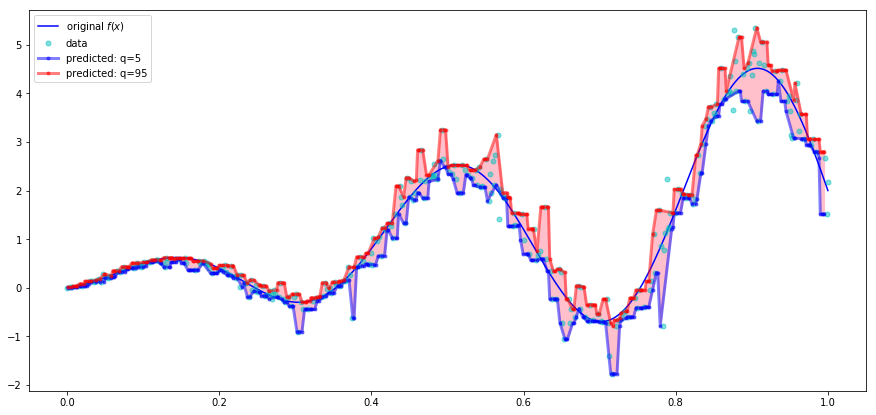

In [64]:
preds_rf_qnt = np.concatenate([rf_quantile(rf, x_test, q) for q in QUANTILES], axis=1)
plt.figure(figsize=(15,7))
plt.plot(x,y_,'b-',label='original $f(x)$');
plt.plot(x_train,y_train,'c.', ms=10, alpha=0.5, label='data');
for i,(q,co) in enumerate(zip(QUANTILES,colors)):
    plt.plot(x_test, preds_rf_qnt[:,i], '.-', color=co, linewidth=3, alpha=0.5, label='predicted: q=%d'%(100*q));
plt.fill_between(x_test.ravel(), preds_rf_qnt[:,0], preds_rf_qnt[:,-1], color='pink')
plt.legend(fontsize=10);

# Gaussian Process Regression

In [13]:
# !pip install GPy

In [14]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, WhiteKernel, ExpSineSquared, ConstantKernel as C

import GPy

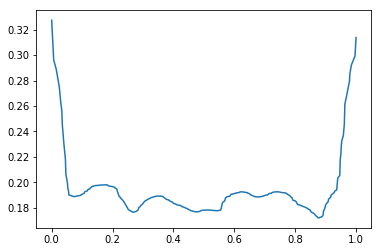

In [15]:
kernel = kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpr = GaussianProcessRegressor(alpha=1, copy_X_train=True,
kernel = Matern(length_scale=1.11, nu=10.5) + WhiteKernel(noise_level=10),
n_restarts_optimizer=20, normalize_y=False,
optimizer='fmin_l_bfgs_b', random_state=None)
gpr = gpr.fit(x_train, y_train)
y_pred, y_std = gpr.predict(x_test, return_std=True)
# plt.plot(x_train, y_std);

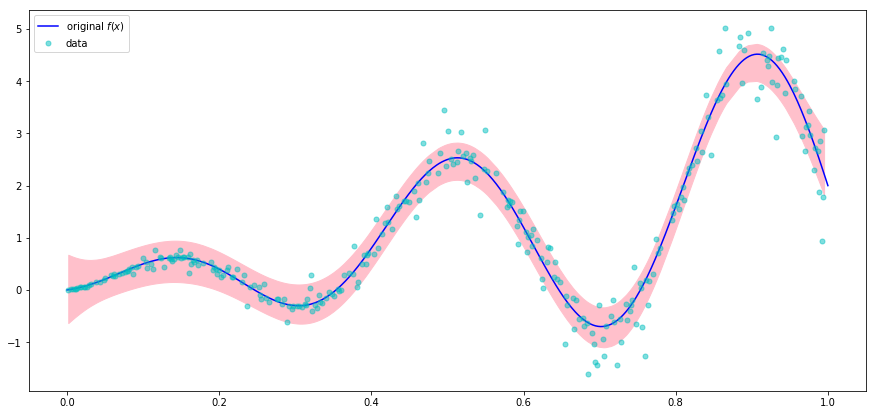

In [16]:
plt.figure(figsize=(15,7))
plt.plot(x,y_,'b-',label='original $f(x)$');
plt.plot(x_test,y_test,'c.', ms=10, alpha=0.5, label='data');
plt.fill_between(x_test.ravel(), y_pred.ravel()-2*y_std.ravel(), y_pred.ravel()+2*y_std.ravel(), color='pink')
plt.legend(fontsize=10);

In [17]:
kernel = GPy.kern.Matern52(input_dim=1, variance=1, lengthscale=1)
# kernel = GPy.kern.MLP(1) + GPy.kern.Bias(1)
m = GPy.models.GPHeteroscedasticRegression(x_train, y_train, kernel=kernel)

m['.*het_Gauss.variance'] = abs(200*eps[tr_ind].ravel())[:,None] #Set the noise parameters to the error in Y
m.het_Gauss.variance.fix() #We can fix the noise term, since we already know it
m.optimize()

 /usr/local/lib/python3.5/dist-packages/paramz/transformations.py:111: RuntimeWarning:divide by zero encountered in log


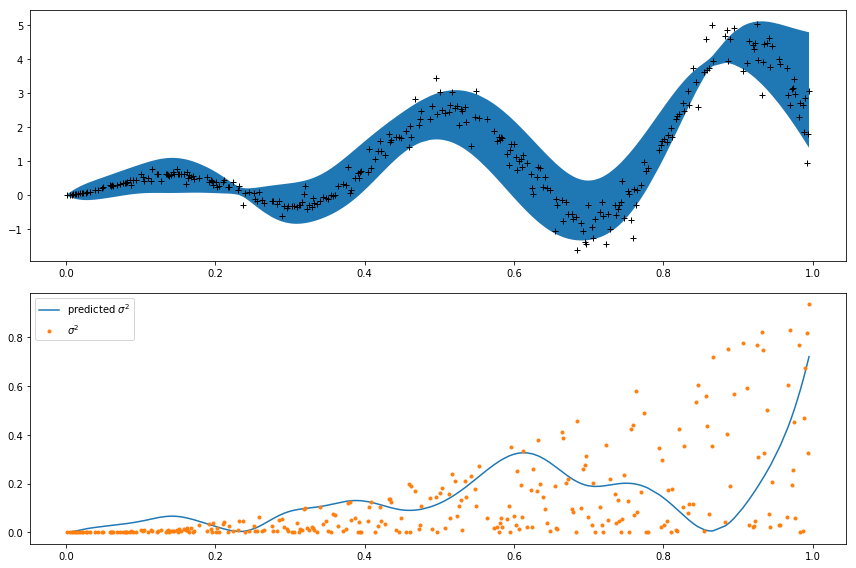

In [18]:
mean, var = m.predict(x_test, include_likelihood=False)
plt.figure(figsize=(12,8))
plt.subplot(2,1,1)
plt.fill_between(x_test.ravel(), mean.ravel()-2*np.sqrt(var).ravel(), mean.ravel()+2*np.sqrt(var).ravel(), label='');
plt.plot(x_test, y_test, 'k+');
plt.subplot(2,1,2)
plt.plot(x_test,var, label='predicted $\sigma^2$')
plt.plot(x_test,s[ts_ind]**2, '.', label='$\sigma^2$')
plt.legend()
plt.tight_layout();

# Neural Network for Gaussian Probabilistic Model 

### The objective is to learn the mean $\mu$ and std $\sigma$ as functions of the input $x$
### Define a simple neural network model that outputs $\mu_{\theta}(x)$ and $\sigma_{\theta}(x)$
### Also, define a loss function as the Gaussian negative log-likelihood
### $\ \ \ -\log(p_{\theta}(y|x)) = \frac{log(\sigma_{\theta}(x)^2)}{2} + \frac{(y-\mu_{\theta}(x))^2}{2\sigma_{\theta}(x)^{2}} + const.$

In [19]:
device = "cuda:0" if GPUtil.getGPUs() else 'cpu'
print("using %s"%device)

using cuda:0


In [66]:
x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).float().to(device)
x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).float().to(device)

## Model

In [67]:
L = [1, 10, 10, 100, 100, 10, 10, 2]

model = torch.nn.Sequential(
    torch.nn.Linear(L[0], L[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[1], L[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[2], L[3]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[3], L[4]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[4], L[5]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[5], L[6]),
    torch.nn.ReLU(),
    torch.nn.Linear(L[6], L[7]),
    torch.nn.Softplus()
).to(device)
model

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=100, bias=True)
  (5): ReLU()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Linear(in_features=100, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=10, bias=True)
  (11): ReLU()
  (12): Linear(in_features=10, out_features=2, bias=True)
  (13): Softplus(beta=1, threshold=20)
)

## Loss

In [68]:
loss_fn = lambda mu, sigma, yi: torch.sum(torch.log(sigma**2) + ((yi - mu)/sigma)**2)

## Training

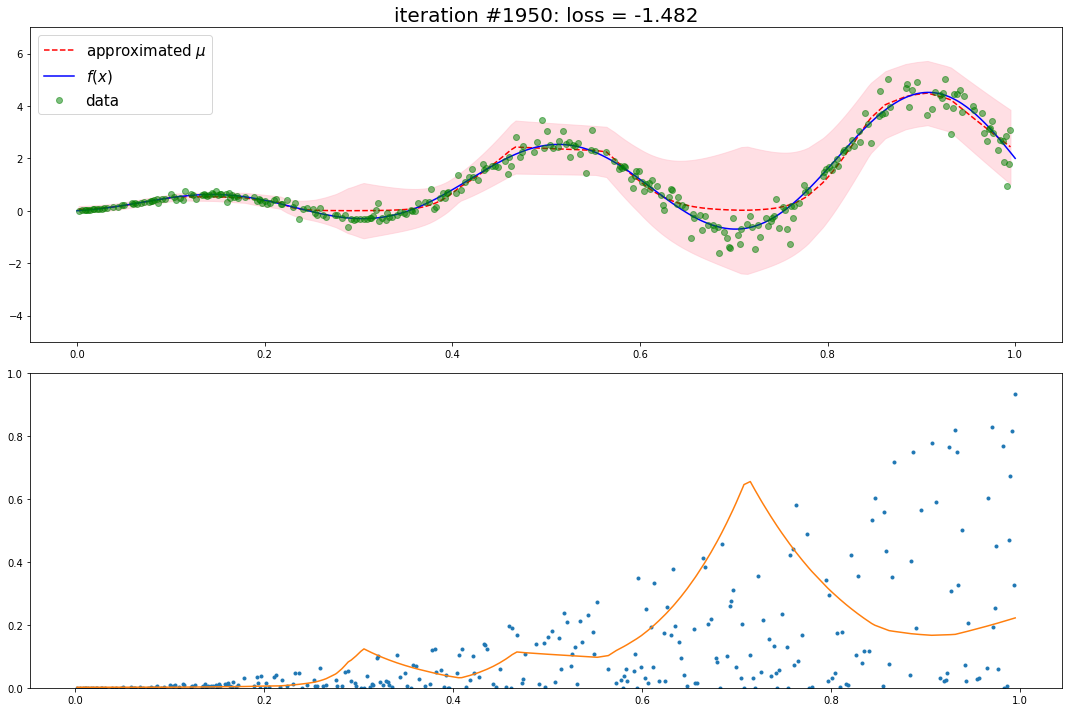

In [69]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=learning_rate)
rng = int(2e3)
plt.figure(figsize=(15,10))
loss_val = 0.
ims = []
for t in range(rng):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_tensor)
    mu, sigma = y_pred[:,0], y_pred[:,1]
    loss = loss_fn(mu, sigma, y_train_tensor.flatten())/y_train_tensor.size(0)
    
    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_test_tensor)
        mu_val, sigma_val = y_pred_val[:,0], y_pred_val[:,1]
        loss_val = loss_fn(mu_val, sigma_val, y_test_tensor.flatten())/y_test_tensor.size(0)

    if(t%50==0):
        mu_val, sigma_val = y_pred_val[:,0].cpu().data.numpy(), y_pred_val[:,1].cpu().data.numpy()
        plt.clf()
        plt.subplot(2,1,1)
        plt.fill_between(x_test.ravel(),mu_val-3*sigma_val,mu_val+3*sigma_val, color='pink', alpha=0.5)
        plt.plot(x_test,mu_val,'r--', label='approximated $\mu$')
        plt.plot(x,y_,'b', label='$f(x)$')
        plt.plot(x_test,y_test,'go', alpha=0.5, label='data');
        plt.title("iteration #%d: loss = %.3f"%(t, loss_val.item()), fontsize=20)
        plt.legend(fontsize=15)
        plt.ylim([-5,7])
        plt.subplot(2,1,2)
        plt.plot(x_test, s[ts_ind]**2, '.', label='true $\sigma^2$')
        plt.plot(x_test, sigma_val**2, label='predicted $\sigma^2$')
        plt.ylim([0,1])
        plt.tight_layout()
        clear_output(wait=True)
        display(plt.gcf())

        
    loss.backward()
    optimizer.step()
clear_output(wait=True)

# MC-Dropout

In [70]:
device = "cuda:0" if GPUtil.getGPUs() else 'cpu'
print("using %s"%device)

using cuda:0


In [71]:
x_train_tensor, y_train_tensor = torch.from_numpy(x_train).float().to(device), torch.from_numpy(y_train).float().to(device)
x_test_tensor, y_test_tensor = torch.from_numpy(x_test).float().to(device), torch.from_numpy(y_test).float().to(device)

In [72]:
loss_fn = lambda mu, yi: torch.sum((yi - mu)**2)

In [73]:
L = [1, 100, 100, 100, 10, 1]
p = 0.1
model = torch.nn.Sequential(
    torch.nn.Linear(L[0], L[1]),
    torch.nn.ReLU(),
    nn.Dropout(p=p),
    torch.nn.Linear(L[1], L[2]),
    torch.nn.ReLU(),
    nn.Dropout(p=p),
    torch.nn.Linear(L[2], L[3]),
    torch.nn.ReLU(),
    nn.Dropout(p=p),
    torch.nn.Linear(L[3], L[4]),
    torch.nn.ReLU(),
    nn.Dropout(p=p),
    torch.nn.Linear(L[4], L[5]),
#     torch.nn.ReLU(),
).to(device)
model

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=100, out_features=100, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): ReLU()
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=100, out_features=10, bias=True)
  (10): ReLU()
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=10, out_features=1, bias=True)
)

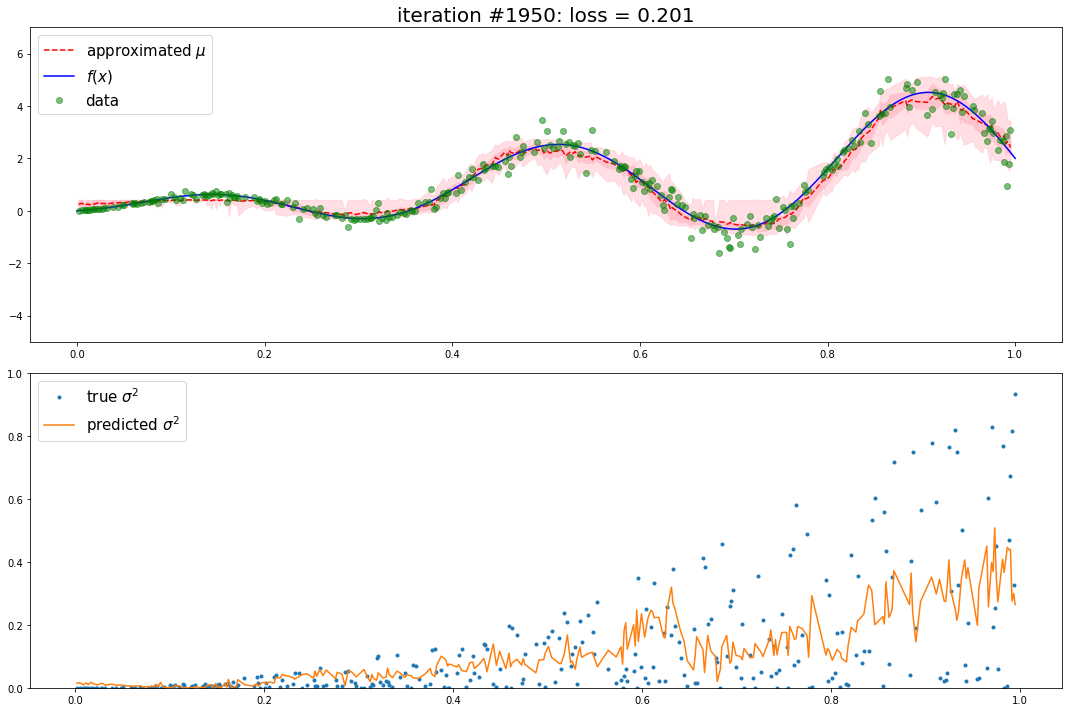

In [74]:
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.1*learning_rate)
rng = int(2e3)
plt.figure(figsize=(15,10))
loss_val = 0.
ims = []
for t in range(rng):
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train_tensor)
    mu, sigma = y_pred[:,0], y_pred[:,0]
    loss = loss_fn(mu, y_train_tensor.flatten())/y_train_tensor.size(0)
    
    with torch.no_grad():
        y_pred_val = torch.cat([model(x_test_tensor) for _ in range(30)], dim=1)
        sigma_val_tensor, mu_val_tensor = torch.std_mean(y_pred_val, dim=1)
        loww, low, high, highh = np.percentile(y_pred_val.cpu().data.numpy(), [2.5, 25, 75, 97.5], axis=1)
        sigma_val, mu_val = sigma_val_tensor.cpu().data.numpy(), mu_val_tensor.cpu().data.numpy()

    if(t%50==0):
        plt.clf()
        plt.subplot(2,1,1)
        plt.plot(x_test,mu_val,'r--', label='approximated $\mu$')
#         plt.fill_between(x_test.ravel(),mu_val-3*sigma_val,mu_val+3*sigma_val, color='pink', alpha=0.5)
        plt.fill_between(x_test.ravel(),loww, highh, color='pink', alpha=0.5)
        plt.fill_between(x_test.ravel(),low, high, color='pink', alpha=0.9)
        plt.plot(x,y_,'b', label='$f(x)$')
        plt.plot(x_test,y_test,'go', alpha=0.5, label='data');
        plt.title("iteration #%d: loss = %.3f"%(t, loss.item()), fontsize=20)
        plt.legend(fontsize=15)
        plt.ylim([-5,7])
        plt.subplot(2,1,2)
        plt.plot(x_test, s[ts_ind]**2, '.', label='true $\sigma^2$')
        plt.plot(x_test, sigma_val**2, label='predicted $\sigma^2$')
        plt.ylim([0,1])
        plt.legend(fontsize=15)
        plt.tight_layout()
        clear_output(wait=True)
        display(plt.gcf())

        
    loss.backward()
    optimizer.step()
clear_output(wait=True)

# Probabilistic Programming
requires python '>=3.5.4'

In [54]:
# !pip install pymc3

In [65]:
import pymc3 as pm
print('Running on PyMC3 v{}'.format(pm.__version__))

In [55]:
plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'m.', ms=10, alpha=0.6, label='train');
plt.plot(x_test,y_test,'c.', ms=10, alpha=0.5, label='test');
deg = 4
xpoly_tr = np.concatenate([x_train**i for i in range(1,deg+1)], axis=1)
xpoly_ts = np.concatenate([x_test**i for i in range(1,deg+1)], axis=1)
lin = LinearRegression().fit(xpoly_tr, y_train)
lin_y_pred = lin.predict(xpoly_ts)
plt.plot(x_test,lin_y_pred, linestyle='--', linewidth=4, alpha=1, label='predicted: deg %d'%(deg-1));
plt.legend(fontsize=15);

1

In [ ]:
with pm.Model():

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal('sigma', sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)

In [ ]:
data = {**{'x%d'%i:xpoly_tr[:,i] for i in range(deg)}, **{'y': y_train.squeeze()}}
xs = ' + '.join(['x%d'%i for i in range(deg)])
formula = 'y ~ %s'%xs
print(formula)
model=pm.Model()
lm = pm.glm.GLM.from_formula(formula, data, model=model)

In [ ]:
data = {**{'x%d'%i:xpoly_tr[:,i] for i in range(deg)}, **{'y': y_train.squeeze()}}
xs = ' + '.join(['x%d'%i for i in range(deg)])
formula = 'y ~ %s'%xs
print(formula)
model=pm.Model()
lm = pm.glm.GLM.from_formula(formula, data, model=model)

start = pm.find_MAP(model=model)
step = pm.Metropolis(model=model)
trace = pm.sample(3000, tune=1000, model=model, start=start, step=step)

In [ ]:
spp = pm.sample_posterior_predictive(trace, model=model, samples=30)
mu, (loww, low, high, highh) = spp['y'].T.mean(axis=1), np.percentile(spp['y'].T, [2.5,25,75,97.5], axis=1)

In [ ]:
plt.figure(figsize=(15,7))
plt.fill_between(x_train.ravel(), loww, highh, alpha=0.3, color='pink', label='credible interval - 2.5%-97.5%')
plt.fill_between(x_train.ravel(), low, high, alpha=0.8, color='pink', label='credible interval - 25%-75%')
plt.plot(x_train, mu, 'r--', label='predcited $\mu$')
plt.plot(x_train, y_train, '.', label='data')
plt.legend();

In [ ]:
pm.traceplot(trace);

In [ ]:
plt.figure(figsize=(15,7))
plt.plot(x_train,y_train,'m.', ms=10, alpha=0.6, label='train');
plt.plot(x_test,y_test,'c.', ms=10, alpha=0.5, label='test');
deg = 9
xpoly_tr = np.concatenate([x_train**i for i in range(1,deg+1)], axis=1)
xpoly_ts = np.concatenate([x_test**i for i in range(1,deg+1)], axis=1)
lin = LinearRegression().fit(xpoly_tr, y_train)
lin_y_pred = lin.predict(xpoly_ts)
plt.plot(x_test,lin_y_pred, linestyle='--', linewidth=4, alpha=1, label='predicted: deg %d'%(deg-1));
plt.legend(fontsize=15);

In [ ]:
data = {**{'x%d'%i:xpoly_tr[:,i] for i in range(deg)}, **{'y': y_train.squeeze()}}
xs = ' + '.join(['x%d'%i for i in range(deg)])
formula = 'y ~ %s'%xs
print(formula)
model=pm.Model()
lm = pm.glm.GLM.from_formula(formula, data, model=model)

start = pm.find_MAP(model=model)
step = pm.Metropolis(model=model)
trace = pm.sample(3000, tune=1000, model=model, start=start, step=step)

In [ ]:
spp = pm.sample_posterior_predictive(trace[-200:], model=model, samples=30)
mu, (loww, low, high, highh) = spp['y'].T.mean(axis=1), np.percentile(spp['y'].T, [2.5,25,75,97.5], axis=1)

In [ ]:
plt.figure(figsize=(15,7))
plt.fill_between(x_train.ravel(), loww, highh, alpha=0.3, color='pink', label='credible interval - 2.5%-97.5%')
plt.fill_between(x_train.ravel(), low, high, alpha=0.8, color='pink', label='credible interval - 25%-75%')
plt.plot(x_train, mu, 'r--', label='predcited $\mu$')
plt.plot(x_train, y_train, '.', label='data')
plt.legend();

In [ ]:
pm.traceplot(trace);